In [60]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations, load_all_vals, load_val
from src.utils.data_loader import load_val_dates

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils.validation import check_is_fitted

import tensorflow as tf

In [137]:
pd.read_parquet('../data/A/train_targets.parquet').to_csv('../data/A/A_train_targets.csv')
pd.read_parquet('../data/A/X_test_estimated.parquet').to_csv('../data/A/A_test_estimated.csv')
pd.read_parquet('../data/A/X_train_estimated.parquet').to_csv('../data/A/A_train_estimated.csv')
pd.read_parquet('../data/A/X_train_observed.parquet').to_csv('../data/A/A_train_observed.csv')

pd.read_parquet('../data/B/train_targets.parquet').to_csv('../data/B/B_train_targets.csv')
pd.read_parquet('../data/B/X_test_estimated.parquet').to_csv('../data/B/B_test_estimated.csv')
pd.read_parquet('../data/B/X_train_estimated.parquet').to_csv('../data/B/B_train_estimated.csv')
pd.read_parquet('../data/B/X_train_observed.parquet').to_csv('../data/B/B_train_observed.csv')

pd.read_parquet('../data/C/train_targets.parquet').to_csv('../data/C/C_train_targets.csv')
pd.read_parquet('../data/C/X_test_estimated.parquet').to_csv('../data/C/C_test_estimated.csv')
pd.read_parquet('../data/C/X_train_estimated.parquet').to_csv('../data/C/C_train_estimated.csv')
pd.read_parquet('../data/C/X_train_observed.parquet').to_csv('../data/C/C_train_observed.csv')

In [62]:
data = load_all_locations()
val_data = load_all_vals()

In [140]:
X = data[0]
X["y"] = data[1].y

X.to_csv('../data/cleaned.csv', index=False)

In [111]:
class DatasetPreparer:
    def __init__(self, n_steps):
        self.X_scaler = MinMaxScaler()
        self.y_scalerA = MinMaxScaler()
        self.y_scalerB = MinMaxScaler()
        self.y_scalerC = MinMaxScaler()
        self.n_steps = n_steps
        self.features = []

    def _is_fit_called(self):
        return (
            hasattr(self.X_scaler, "n_features_in_")
            and hasattr(self.y_scalerA, "n_features_in_")
            and hasattr(self.y_scalerB, "n_features_in_")
            and hasattr(self.y_scalerC, "n_features_in_")
        )

    def _fit_by_location(self, y_df):
        self.y_scalerA = self.y_scalerA.fit(y_df[y_df.location == "A"][["y"]])
        # self.y_scalerB = self.y_scalerB.fit(y_df[y_df.location == "B"][["y"]])
        # self.y_scalerC = self.y_scalerC.fit(y_df[y_df.location == "C"][["y"]])

    def _scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.transform(
                y_df[y_df.location == "A"][["y"]]
            )
        # if "B" in list(y_df.location):
        #     y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.transform(
        #         y_df[y_df.location == "B"][["y"]]
        #     )
        # if "C" in list(y_df.location):
        #     y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.transform(
        #         y_df[y_df.location == "C"][["y"]]
        #     )

        return y_df["y"]

    def inverse_scale_by_location(self, y_df):
        if "A" in list(y_df.location):
            y_df.loc[y_df.location == "A", "y"] = self.y_scalerA.inverse_transform(
                y_df[y_df.location == "A"][["y"]]
            )
        # if "B" in list(y_df.location):
        #     y_df.loc[y_df.location == "B", "y"] = self.y_scalerB.inverse_transform(
        #         y_df[y_df.location == "B"][["y"]]
        #     )
        # if "C" in list(y_df.location):
        #     y_df.loc[y_df.location == "C", "y"] = self.y_scalerC.inverse_transform(
        #         y_df[y_df.location == "C"][["y"]]
        #     )

        return y_df

    def prepare(self, X_df, y_df=None):
        df = X_df.copy()

        # Drop missing column values
        nan_columns = df.columns[df.isna().any()].tolist()
        df = df.drop(columns=nan_columns)

        df = df[
            [
                "direct_rad:W",
                "diffuse_rad:W",
                "effective_cloud_cover:p",
                "t_1000hPa:K",
                "absolute_humidity_2m:gm3",
                "sun_azimuth:d",
                "clear_sky_rad:W",
                "air_density_2m:kgm3",
                "elevation:m",
                "relative_humidity_1000hPa:p",
                "sun_elevation:d",
                "visibility:m",
                "wind_speed_v_10m:ms"
            ]
        ]

        self.features = df.columns

        if not isinstance(y_df, pd.DataFrame):
            X_as_array = self.X_scaler.transform(df)
            return X_as_array[2:-2]

        y_df = y_df.copy()

        # Scaling
        if not self._is_fit_called():
            self.X_scaler = self.X_scaler.fit(df)
            self._fit_by_location(y_df)

        X_as_array = self.X_scaler.transform(df)
        y_as_array = np.array(self._scale_by_location(y_df))

        X = []
        y = []

        if self.n_steps == 0:
            return X_as_array[2:-2], y_as_array[2:-2]

        for i in range(len(X_as_array) - self.n_steps):
            row = [a for a in X_as_array[i : i + self.n_steps]]
            X.append(row)
            label = y_as_array[i + self.n_steps]
            y.append(label)

        return np.array(X), np.array(y)

In [86]:
# Simulate Kaggle validation set

vals = load_all_vals()
vals["test"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0, 1)
vals["test2"] = np.where(vals["absolute_humidity_2m:gm3"].isna(), 0.1, 0.9)

val_dates = pd.DataFrame(columns=["time"], data=load_val_dates())
val_dates.time = pd.to_datetime(val_dates.time)

# Get dates of our validation set, offset in order to get the correct test-set timeframe
test_dates = val_dates.copy()
test_dates = test_dates - pd.DateOffset(days=365)

In [112]:
test_size = 5000
window_size = 3

X_data_train = data[0][(data[0].set_type == "TRAIN") & ~(data[0].time.isin(test_dates.time)) & (data[0].location == "A")].iloc[:-test_size]
y_data_train = data[1][(data[1].set_type == "TRAIN") & ~(data[1].time.isin(test_dates.time)) & (data[1].location == "A")].iloc[:-test_size]

X_data_test = data[0][(data[0].set_type == "TRAIN") & (data[0].location == "A")].iloc[-test_size:]
y_data_test = data[1][(data[1].set_type == "TRAIN") & (data[1].location == "A")].iloc[-test_size:]
X_data_val = data[0][data[0].time.isin(test_dates.time) & (data[0].location == "A")]
y_data_val = data[1][data[1].time.isin(test_dates.time) & (data[1].location == "A")]

X_data_kaggle = val_data[val_data.time.isin(val_dates.time)]

preparer = DatasetPreparer(n_steps=window_size)

X_train, y_train = preparer.prepare(X_data_train, y_data_train)
X_test, y_test = preparer.prepare(X_data_test, y_data_test)
X_val, y_val = preparer.prepare(X_data_val, y_data_val)
X_kaggle = preparer.prepare(X_data_kaggle, None)

print(
    "TRAIN:",
    X_train.shape,
    y_train.shape,
    "\nTEST:",
    X_test.shape,
    y_test.shape,
    "\nVAL:",
    X_val.shape,
    y_val.shape,
    "\nKAGGLE:",
    X_kaggle.shape,
    "\nFEATURES:",
    len(preparer.features),
)

TRAIN: (23902, 3, 13) (23902,) 
TEST: (4997, 3, 13) (4997,) 
VAL: (717, 3, 13) (717,) 
KAGGLE: (2156, 13) 
FEATURES: 13


In [133]:
# Tensorflow LSTM model with lookback


def create_model(n_steps, n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(64, activation="relu", input_shape=(n_steps, n_features), return_sequences=True))
    model.add(tf.keras.layers.LSTM(128, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.1))
    # model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="mae")

    return model

model = create_model(window_size, len(preparer.features))
model.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 3, 64)             19968     
                                                                 
 lstm_42 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 118,913
Trainable params: 118,913
Non-trainable params: 0
_________________________________________________________________


In [134]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=72,
)

Epoch 1/50
332/332 [==============================] - 4s 6ms/step - loss: 0.1047 - val_loss: 0.1888
Epoch 2/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0982 - val_loss: 0.1758
Epoch 3/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0918 - val_loss: 0.1598
Epoch 4/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0855 - val_loss: 0.1444
Epoch 5/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0797 - val_loss: 0.1323
Epoch 6/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0751 - val_loss: 0.1255
Epoch 7/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0718 - val_loss: 0.1200
Epoch 8/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0692 - val_loss: 0.1159
Epoch 9/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0668 - val_loss: 0.1128
Epoch 10/50
332/332 [==============================] - 2s 6ms/step - loss: 0.0650 - val_loss: 0.1094

KeyboardInterrupt: 

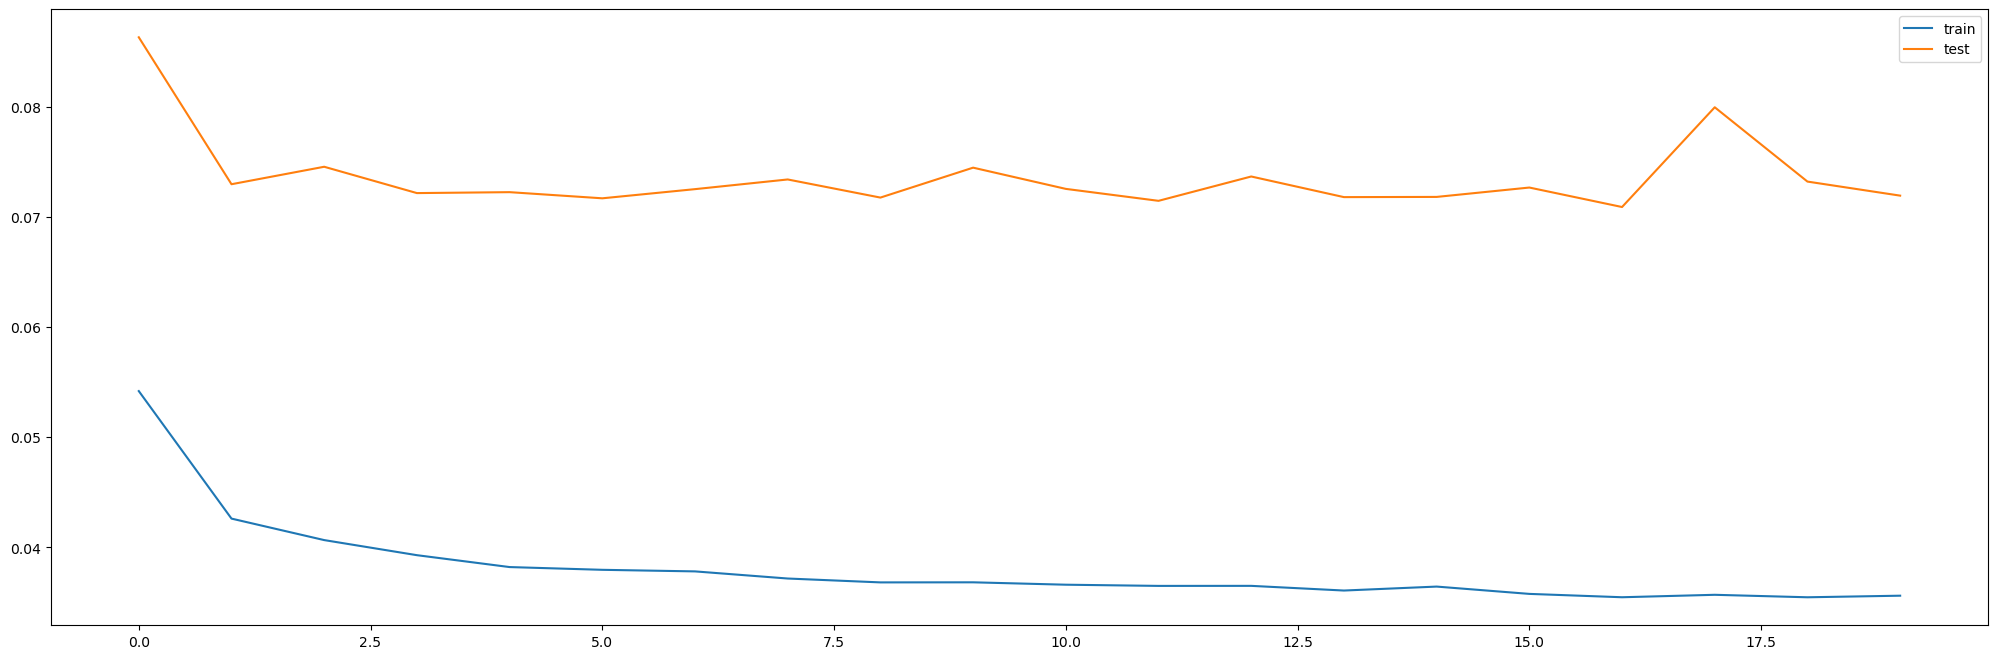

In [115]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

23/23 [==============================] - 0s 1ms/step


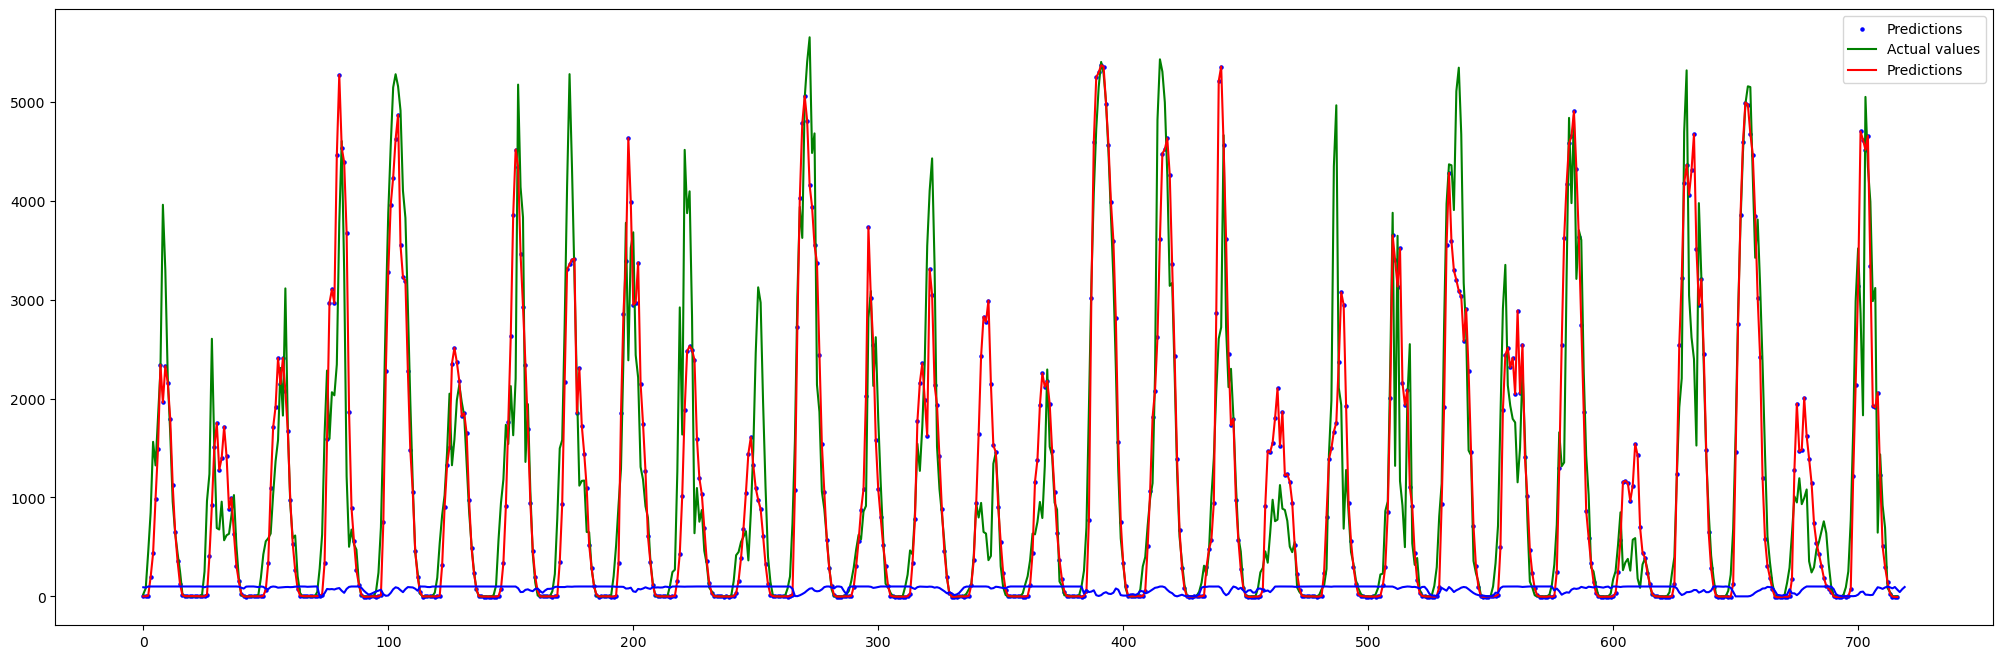

In [116]:
preds_val = model.predict(X_val)

y_val_df = y_data_val.copy().iloc[window_size:]
y_val_df["actual"] = y_val_df["y"]
y_val_df["y"] = preds_val
y_val_df = preparer.inverse_scale_by_location(y_val_df)

X_val_df = X_data_val.copy().iloc[window_size:]

plt.rcParams["figure.figsize"] = [25, 8]
plt.scatter(y_val_df.reset_index().index, y_val_df["y"], c="blue", s=5)
plt.plot(y_val_df["actual"].tolist(), c="green")
plt.plot(y_val_df["y"].tolist(), c="red")
plt.plot(X_data_val["total_cloud_cover:p"].tolist(), c="blue")
plt.legend(["Predictions", "Actual values", "Predictions"])
plt.show()